In [1]:
#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
#import scipy as sp
from scipy.signal import find_peaks
import peakutils

In [2]:
#assign filename variable
#example input: 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_08_22_Myometrial_Contractility_Study_4_MB_9_16.tsv


In [3]:
#import data from excel reference file
#import muscle bath tsv file (as pandas dataframe?)
#import corresponding comments file
df_file = pd.read_csv(filename, sep='\t')
df_ref = pd.read_csv(ref_filename, sep='\t')
comments_file = open(comments_filename,'r')
df_ref.head()

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,2018_08_13_Human_Uterine.tsv,1,1,1,NaN,1.0,0.1,Adiponectin,100.0,21.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018_08_13_Human_Uterine.tsv,1,1,2,NaN,0.0,0.0,Adiponectin,100.0,25.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018_08_13_Human_Uterine.tsv,1,1,3,NaN,1.0,0.1,Adiponectin,1000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018_08_13_Human_Uterine.tsv,1,1,4,NaN,0.0,0.0,Adiponectin,1000.0,24.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018_08_13_Human_Uterine.tsv,1,1,5,NaN,1.0,0.1,TNF_alpha,0.1,29.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])

In [5]:
#drop unneccessary columns
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#view first 5 rows of input file
df_file.head()

,Comments,Force1,Force2,Force3,Force4,Force5,Force6,Force7,Force8
Experiment Time,,,,,,,,,
0.0,NaN,6.991,1.554,2.808,0.01201,0.02334,0.06398,-0.02605,0.02910
1.0,NaN,6.994,1.569,2.814,0.02102,0.02786,0.05370,-0.04315,0.01724
2.0,NaN,6.980,1.551,2.803,0.02853,0.04970,0.06398,-0.04722,0.03233
3.0,NaN,6.979,1.560,2.828,0.03604,0.03012,0.03999,-0.04315,0.02586
4.0,NaN,6.979,1.557,2.808,0.02402,0.02636,0.05712,-0.04803,0.02910


In [6]:
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:14]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#view processed input file
df_ref.head()

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
38,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,10,NaN,0.0,0.00,Adiponectin,100.0,24.69,1.36,2.12,67.0,NaN
39,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,11,NaN,1.0,0.05,TNF_alpha,10.0,19.17,1.41,1.47,44.0,NaN


In [7]:
#reset df_ref index, starting at 0
df_ref.set_index([pd.Index(list(range(len(df_ref))))])

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
0,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,10,NaN,0.0,0.00,Adiponectin,100.0,24.69,1.36,2.12,67.0,NaN
1,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,11,NaN,1.0,0.05,TNF_alpha,10.0,19.17,1.41,1.47,44.0,NaN


In [8]:
#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
count = 0
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(input("What time does baseline end"))
    baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[count]])
    baseline_array_list.append(baseline_array)
    count += 1

Pitocin Bath 9 : 7418.0
Pitocin Bath 11 : 7584.4
Baseline : 11699.3
Treatment Bath 10 : 15705.8
Treatment Bath 11 : 15741.6
Muscle Bath 10 :
What time does baseline end15705
Muscle Bath 11 :
What time does baseline end15741


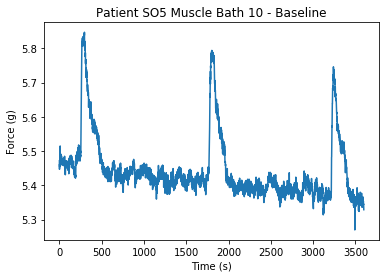

patientSO5_bath10_baseline.pdf


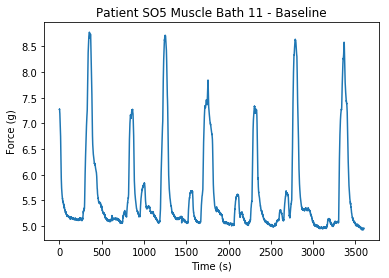

patientSO5_bath11_baseline.pdf


In [9]:
#plot the baseline contraction force data from
#for bath in df_ref['Bath Number']:
for i in range(len(baseline_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Baseline")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')

In [10]:
#loop through muscle baths in reference dataframe 
    #for each bath listed in the reference file, find the local max 
    #for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr
#create storage lists for outputs
locmax_list = []
fp_output_list = []
#for loop for peak analysis
#vary width variable for each study to tune the find_peaks function
width_var = float(input("input the width variable for find_peaks function:"))
for i in range(len(baseline_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    cutoff = float(input("input peak height cutoff:"))
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(baseline_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(baseline_array_list[(i)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)
#width variable used for analysis of each study:    
#width_var = 8 for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
#width_var = 35 for 2018_12_07_Myometrial_Contractility_Study_14_a.tsv
#width_var = 35 for 2018_12_13_Myometrial_Contractility_Study_15_MBa.tsv
#width_var = 40 for 2018_12_17_Myometrial_Contractility_Study_16_MBa.tsv
#width_var = 25 for 2019_01_28_Myometrial_Contractility_Study_17_MBa.tsv

input the width variable for find_peaks function:30
Muscle Bath 10 :
input peak height cutoff:5.6
Muscle Bath 11 :
input peak height cutoff:7


In [11]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

In [12]:
#?? peakutils.baseline


How long (sec) before a peak should the local min baseline begin?90
Duration (sec) of local min baseline:5
Muscle Bath 10


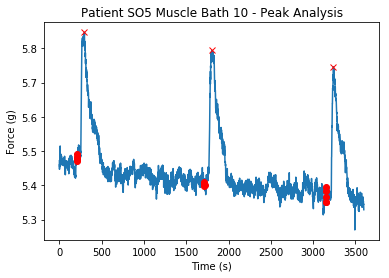

peakanalysisgraphs_patientSO5_bath10_baseline.pdf
mean baseline force: [5.481      5.4038     5.36962286]
Muscle Bath 11


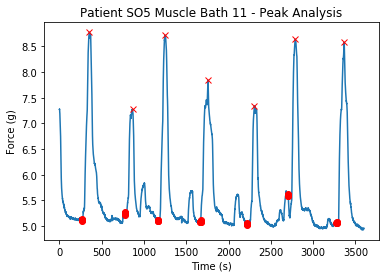

peakanalysisgraphs_patientSO5_bath11_baseline.pdf
mean baseline force: [5.11629812 5.2554     5.1018     5.087      5.04494286 5.6062
 5.07250857]


In [13]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
startlist = []
#create an empty list to store end indices
endlist = []
#create an empty list to store an arrays of baseline values
base_val_list = []
#create an empty list to temporarily store baseline means
templist = []
#create an empty list to append array of baseline means
base = []
#
timebeforepeak = int(input("How long (sec) before a peak should the local min baseline begin?"))
baselineduration = int(input("Duration (sec) of local min baseline:"))
#loop through muscle baths
for x in range(len(df_ref)):
    bath = df_ref.iloc[x]["Bath Number"]
    #reset lists
    startlist = []
    endlist = []
    base_val_list = []
    templist = []
    print("Muscle Bath",bath)
    #loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
    #store values in startlist and endlist
    for peak_time in locmax_indx_list[x]:
        #vary start time and end time in order to find proper baseline local min
        #parameters for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
        #starttime = peak_time - 60
        #endtime = peak_time - 55
        #parameters for 2018_12_07_Myometrial_Contractility_Study_14_a.tsv
        #starttime = peak_time - 60
        #endtime = peak_time - 55
        #parameters for 2018_12_13_Myometrial_Contractility_Study_15_MBa.tsv
        #starttime = peak_time - 70
        #endtime = peak_time-60
        #parameters for 2018_12_17_Myometrial_Contractility_Study_16_MBa.tsv
        #starttime = peak_time - 70
        #endtime = peak_time-60
        starttime = peak_time - timebeforepeak
        endtime = starttime + baselineduration
        if starttime < 0:
            starttime = 0
        if endtime < 0:
            endtime = 2
        startlist.append(starttime)
        endlist.append(endtime)
    #loop through contractions, calculate baseline values, assign values to spot in base_val_list
    for i in range(len(startlist)):
        baseline_values = peakutils.baseline(np.array(baseline_array_list[x])[startlist[i]:endlist[i]])
        base_val_list.append(baseline_values)
    #plot muscle baths with local min baseline and local max values highlighted     
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[x])) 
    plt.title("Patient "+list(df_ref['Patient'])[x]+" Muscle Bath "+str(bath)+" - Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for counter, base_data in enumerate(base_val_list):
        plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'ro')
    for counter, peak in enumerate(locmax_list[x]):
        plt.plot(locmax_indx_list[x][counter],peak,'rx')
    plt.show()
    savestring = "peakanalysisgraphs_" + "patient"+(list(df_ref['Patient'])[x])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')
    #average local min baseline data
    for base_val in base_val_list:
        #altered code to calculate the minimum value of baseline instead of average*******
        templist.append(base_val.mean())
        #templist.append(base_val.min())
        base_mean_array = np.array(templist)
    print("mean baseline force:",base_mean_array)
    #store local min baseline data in list
    base.append(base_mean_array)

In [14]:
#baseline peak force calculations
#create an empty list to store raw forces and titles
raw_force_list = []
forcetitles = []
#calculate baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    forcetitles.append(title)
    for contract in range(len(locmax_list[x])):
        amp = (locmax_list[x][contract]-base[x][contract])
        templist.append(amp)
    raw_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
rawforcedic = dict(zip(forcetitles, raw_force_list))
#for each muscle bath calculate the average raw peak value during baseline
#this will be used for treatment peak normalization
#create empty storage lists 
basepeakmean = []
#for loop calculation 
for bath in range(len(raw_force_list)):
    basepeakmean.append(raw_force_list[bath].mean())  
#calculate cross-sectional area (CSA)
CSA_list = []
for bath in df_ref['Bath Number']:
    length = float(df_ref[df_ref['Bath Number']== bath]['Length (mm)'])
    mass = float(df_ref[df_ref['Bath Number']== bath]['Mass (mg)'])
    CSA = (length *1.056)/mass
    CSA_list.append(CSA)
#create an empty list to store raw forces and titles
norm_force_list = []
normtitles = []
#calculate CSA normalized baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" norm (g/CSA)"
    normtitles.append(title)
    for contraction in range(len(locmax_list[x])):
        norm = ((locmax_list[x][contraction]-base[x][contraction])/CSA_list[x])
        templist.append(norm)
    norm_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
normforcedic = dict(zip(normtitles, norm_force_list))
#calculate mean NORMALIZED force for each muscle bath and standard deviation
#may not be useful
#standard deviation may say something about stability of recovery
#create empty storage lists 
CSAmean = []
CSAstd = []
#for loop calculation
counter = 0    
for bath in df_ref['Bath Number']:
    CSAmean.append(norm_force_list[counter].mean())
    CSAstd.append(norm_force_list[counter].std())
    counter+=1

In [15]:
#sending baseline data to Excel spreadsheet

#create a dataframe to store raw force data
df_raw = pd.DataFrame.from_dict(rawforcedic, orient='index')
df_raw = df_raw.transpose()
#create a dataframe to store normalized data
df_norm = pd.DataFrame.from_dict(normforcedic, orient='index')
df_norm = df_norm.transpose()
#create output baseline dataframe
df_base_out = df_raw.join(df_norm)
df_base_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
base_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_baseline_"+computer+".xlsx"
df_base_out.to_excel(base_out_file)
print(base_out_file)

PatientSO5_baseline_comp2.xlsx


In [19]:
#gradients=np.diff(np.array(baseline_array_list[0]))
#print(np.argmax(gradients))
#np.array(baseline_array_list[0])[2309]

#subtract minimum value from peak force to calculate amplitude of contraction
#calculate mean value of contraction amplitude
#calculate standard deviation
#calculate contractions amplitude corrected to CSA
#calculate mean value of contractions amplitude/CSA
#calculate standard deviation of contractions amplitude/CSA


#from max/min calculate the amplitudes/peaks
#calculate the average for each bath
#calculate the peaks 

#loop through baths and find peak forces
#input function to determine when baseline period should be

In [229]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [230]:
comments_file.close()